# Industry 4.0 의 중심, AI - ML&DL

<div align='right'><font size=2 color='gray'>Machine Learning & Deep Learning with TensorFlow @ <font color='blue'><a href='https://www.facebook.com/jskim.kr'>FB / jskim.kr</a></font>, 김진수</font></div>
<hr>

# Sect12. RNN (Recurrent Newural Network)

In [1]:
from images import bigpycraft_ai as bpc
from IPython.display import Image 
from tqdm import tqdm_notebook

In [2]:
import time
import os

def chk_processting_time(start_time, end_time):
    process_time = end_time - start_time
    p_time = int(process_time)
    p_min = p_time // 60
    p_sec = p_time %  60
    print('처리시간 : {p_min}분 {p_sec}초 경과되었습니다.'.format(
            p_min = p_min, 
            p_sec = p_sec
        ))
    return process_time

### 12-5. rnn_stock_prediction

<hr>
``` python 

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
tf.set_random_seed(777)  # reproducibility


def MinMaxScaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    # noise term prevents the zero division
    return numerator / (denominator + 1e-7)


timesteps = seq_length = 7
data_dim = 5
output_dim = 1

# Open, High, Low, Volume, Close
xy = np.loadtxt('./data/data-02-stock_daily.csv', delimiter=',')
xy = xy[::-1]  # reverse order (chronically ordered)
xy = MinMaxScaler(xy)
x = xy
y = xy[:, [-1]]  # Close as label

dataX = []
dataY = []
for i in range(0, len(y) - seq_length):
    _x = x[i:i + seq_length]
    _y = y[i + seq_length]  # Next close price
    print(_x, "->", _y)
    dataX.append(_x)
    dataY.append(_y)

# split to train and testing
train_size = int(len(dataY) * 0.7)
test_size = len(dataY) - train_size
trainX, testX = np.array(dataX[0:train_size]), np.array(
    dataX[train_size:len(dataX)])
trainY, testY = np.array(dataY[0:train_size]), np.array(
    dataY[train_size:len(dataY)])

# input place holders
X = tf.placeholder(tf.float32, [None, seq_length, data_dim])
Y = tf.placeholder(tf.float32, [None, 1])

cell = tf.contrib.rnn.BasicLSTMCell(num_units=output_dim, state_is_tuple=True)
outputs, _states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
Y_pred = outputs[:, -1]  # We use the last cell's output

print(outputs[:, -1])

# cost/loss
loss = tf.reduce_sum(tf.square(Y_pred - Y))  # sum of the squares
# optimizer
optimizer = tf.train.GradientDescentOptimizer(0.01)
train = optimizer.minimize(loss)

# RMSE
targets = tf.placeholder(tf.float32, [None, 1])
predictions = tf.placeholder(tf.float32, [None, 1])
rmse = tf.sqrt(tf.reduce_mean(tf.square(targets - predictions)))

sess = tf.Session()
sess.run(tf.global_variables_initializer())

for i in range(500):
    _, step_loss = sess.run([train, loss], feed_dict={X: trainX, Y: trainY})
    print(i, step_loss)

testPredict = sess.run(Y_pred, feed_dict={X: testX})
print("RMSE", sess.run(rmse, feed_dict={
      targets: testY, predictions: testPredict}))
plt.plot(testY)
plt.plot(testPredict)
plt.xlabel("Time Period")
plt.ylabel("Stock Price")
plt.show()


```

<hr>

In [3]:
import platform
import tensorflow as tf

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

%matplotlib inline
plt.rcParams["figure.figsize"] = [12,6]

C:\Python\Anaconda3-50\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


<hr>
### 주식가격현황 분석

In [4]:
datafile = './data/data-02-stock_daily.csv'

In [5]:
stock_df = pd.read_csv(datafile)
stock_df.head(10)

,,,,# http://finance.yahoo.com/quote/GOOG/history?ltr=1
# Open,High,Low,Volume,Close
828.659973,833.450012,828.349976,1247700,831.659973
823.02002,828.070007,821.655029,1597800,828.070007
819.929993,824.400024,818.97998,1281700,824.159973
819.359985,823,818.469971,1304000,818.97998
819,823,816,1053600,820.450012
816,820.958984,815.48999,1198100,819.23999
811.700012,815.25,809.780029,1129100,813.669983
809.51001,810.659973,804.539978,989700,809.559998
807,811.840027,803.190002,1155300,808.380005


In [6]:
stock_df.info

<bound method DataFrame.info of                                          # http://finance.yahoo.com/quote/GOOG/history?ltr=1
# Open     High       Low        Volume                                               Close 
828.659973 833.450012 828.349976 1247700                                         831.659973 
823.02002  828.070007 821.655029 1597800                                         828.070007 
819.929993 824.400024 818.97998  1281700                                         824.159973 
819.359985 823        818.469971 1304000                                          818.97998 
819        823        816        1053600                                         820.450012 
816        820.958984 815.48999  1198100                                          819.23999 
811.700012 815.25     809.780029 1129100                                         813.669983 
809.51001  810.659973 804.539978 989700                                          809.559998 
807        811.840027 803.190002 11553

In [7]:
stock_df = pd.read_csv(datafile, header=1)
stock_df.head()

,# Open,High,Low,Volume,Close
0,828.659973,833.450012,828.349976,1247700,831.659973
1,823.020020,828.070007,821.655029,1597800,828.070007
2,819.929993,824.400024,818.979980,1281700,824.159973
3,819.359985,823.000000,818.469971,1304000,818.979980
4,819.000000,823.000000,816.000000,1053600,820.450012


In [8]:
stock_df.rename(columns={stock_df.columns[0] : 'Open'}, inplace=True)
stock_df.head()

,Open,High,Low,Volume,Close
0,828.659973,833.450012,828.349976,1247700,831.659973
1,823.020020,828.070007,821.655029,1597800,828.070007
2,819.929993,824.400024,818.979980,1281700,824.159973
3,819.359985,823.000000,818.469971,1304000,818.979980
4,819.000000,823.000000,816.000000,1053600,820.450012


In [9]:
stock_df[::100]

,Open,High,Low,Volume,Close
0,828.659973,833.450012,828.349976,1247700,831.659973
100,775.500000,785.989990,774.307983,1153200,783.010010
200,697.700012,702.320007,695.719971,1683500,701.429993
300,752.849976,755.849976,743.830017,1984900,749.460022
400,655.210022,673.000000,654.299988,3377200,662.299988
500,543.212476,556.142529,541.502464,2311500,555.482516
600,567.312567,571.912585,563.322559,1178400,570.082554
700,523.512391,530.192393,519.012379,1912500,529.922427


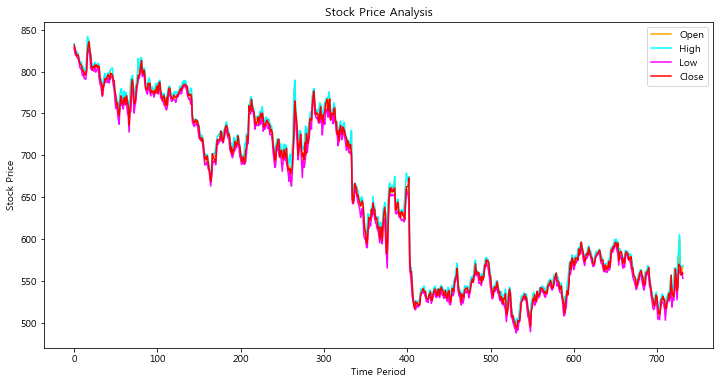

In [10]:
t_val = stock_df.index
y_val = stock_df.Close

vol_df = stock_df.Volume/10000
# vol_df.plot(kind='bar', color='gray', label='Volume')

plt.plot(stock_df.Open,  label='Open',  color='orange')
plt.plot(stock_df.High,  label='High',  color='cyan')
plt.plot(stock_df.Low,   label='Low',   color='magenta')
plt.plot(stock_df.Close, label='Close', color='red')
# stock_df.Volume/10000, label='Volume', color='#FF00FF'

plt.legend()
plt.title('Stock Price Analysis')
plt.xlabel("Time Period")
plt.ylabel("Stock Price")
plt.show()


In [11]:
def draw_graph(stock_df, t_start=0, t_end=100, t_step=1, show_volume=False):
    # stock_df.Volume/10000, label='Volume', color='#FF00FF'
    plt.plot(stock_df.Open  [t_start:t_end:t_step], label='Open',  color='orange')
    plt.plot(stock_df.High  [t_start:t_end:t_step], label='High',  color='blue')
    plt.plot(stock_df.Low   [t_start:t_end:t_step], label='Low',   color='green')
    plt.plot(stock_df.Close [t_start:t_end:t_step], label='Close', color='red')  
    
    if show_volume:
        # volume_df = stock_df.Volume[t_start:t_end:t_step]/100000
        # volume_df = stock_df.Volume[t_start:t_end:t_step]/stock_df.Volume.max() * stock_df.Close.median()
        ratio =  stock_df.Close.median() / stock_df.Volume.median()
        volume_df = stock_df.Volume[t_start:t_end:t_step] * ratio
        volume_df.plot(kind='bar', color='gray', label='Volume')

    plt.legend()
    plt.title('주식가격현황')
    plt.xlabel("Time Period")
    plt.ylabel("Stock Price")
    plt.show()
    

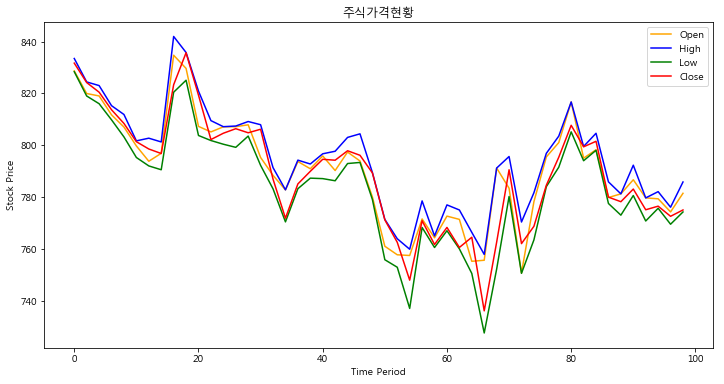

In [12]:
t_start = 0
t_end   = len(stock_df)
t_end   = 100
t_step  = 2
draw_graph(stock_df, t_start, t_end, t_step, show_volume=False)

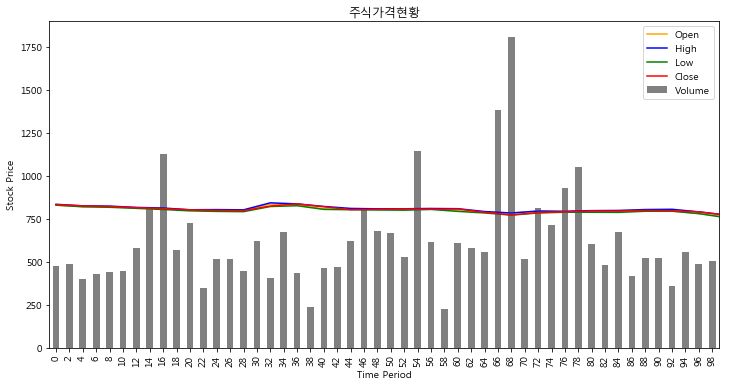

In [13]:
draw_graph(stock_df, t_start, t_end, t_step, show_volume=True)

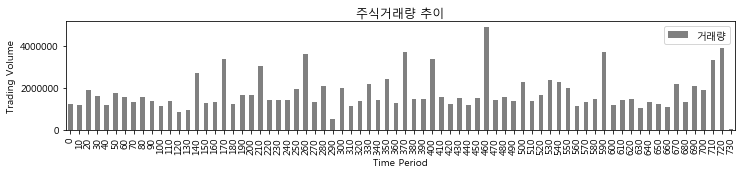

In [14]:
plt.figure(figsize=(12,2))
vol_df = stock_df.Volume[::10]
vol_df.plot(kind='bar', color='gray', label='거래량')

plt.legend()
plt.title('주식거래량 추이')
plt.xlabel("Time Period")
plt.ylabel("Trading Volume")
plt.show()


In [15]:
stock_df.iloc[0:5]

,Open,High,Low,Volume,Close
0,828.659973,833.450012,828.349976,1247700,831.659973
1,823.020020,828.070007,821.655029,1597800,828.070007
2,819.929993,824.400024,818.979980,1281700,824.159973
3,819.359985,823.000000,818.469971,1304000,818.979980
4,819.000000,823.000000,816.000000,1053600,820.450012


In [16]:
price_df = stock_df.iloc[0:100:10][['Open', 'High', 'Low', 'Close']]
price_df

,Open,High,Low,Close
0,828.659973,833.450012,828.349976,831.659973
10,799.700012,801.669983,795.250000,801.340027
20,807.250000,820.869995,803.739990,819.309998
30,795.260010,807.900024,792.203979,806.150024
40,795.840027,796.676025,787.099976,794.559998
50,761.000000,771.359985,755.799988,771.190002
60,772.630005,776.960022,767.000000,768.270020
70,783.400024,795.632996,780.190002,790.510010
80,816.679993,816.679993,805.140015,807.669983
90,786.659973,792.280029,780.580017,783.070007


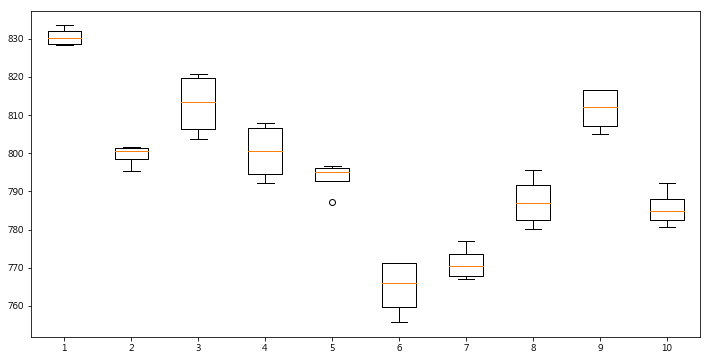

In [17]:
plt.boxplot(price_df)
plt.show()

In [18]:
def draw_candle(stock_df, t_start=0, t_end=100, t_step=1):

    price_df = stock_df.iloc[t_start:t_end:t_step][['Open', 'High', 'Low', 'Close']]
    price_df
    
    plt.boxplot(price_df)
    plt.grid()

    plt.title('주식가격추이')
    plt.xlabel("Time Period")
    plt.ylabel("Stock Price")
    
    plt.show()
    

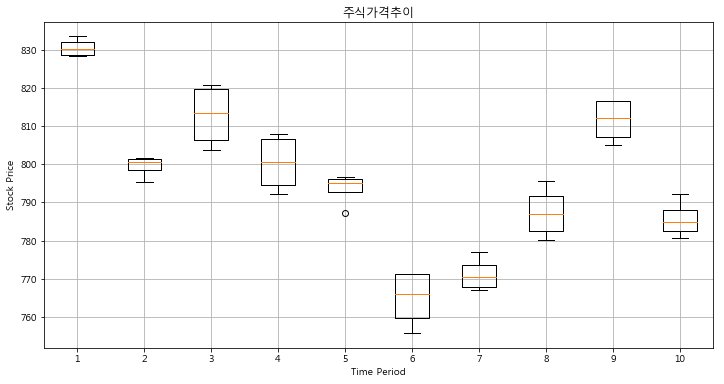

In [19]:
plt.figure(figsize=(12,6))
t_start = 0
t_end   = len(stock_df)
t_end   = 100
t_step  = 10

draw_candle(stock_df, t_start, t_end, t_step)


<hr>
### 주식가격추이 예측

In [20]:
def MinMaxScaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    # noise term prevents the zero division
    return numerator / (denominator + 1e-7)

In [21]:
timesteps = seq_length = 7
data_dim = 5
output_dim = 1

# Open, High, Low, Volume, Close
xy = np.loadtxt('./data/data-02-stock_daily.csv', delimiter=',')
xy

array([[8.28659973e+02, 8.33450012e+02, 8.28349976e+02, 1.24770000e+06,
        8.31659973e+02],
       [8.23020020e+02, 8.28070007e+02, 8.21655029e+02, 1.59780000e+06,
        8.28070007e+02],
       [8.19929993e+02, 8.24400024e+02, 8.18979980e+02, 1.28170000e+06,
        8.24159973e+02],
       ...,
       [5.66892592e+02, 5.67002574e+02, 5.56932537e+02, 1.08000000e+04,
        5.56972503e+02],
       [5.61202549e+02, 5.66432590e+02, 5.58672539e+02, 4.12000000e+04,
        5.59992565e+02],
       [5.68002570e+02, 5.68002570e+02, 5.52922516e+02, 1.31000000e+04,
        5.58462551e+02]])

In [22]:
xy = xy[::-1]  # reverse order (chronically ordered)
xy = MinMaxScaler(xy)
x = xy
y = xy[:, [-1]]  # Close as label


In [23]:
x.shape, y.shape

((732, 5), (732, 1))

In [24]:
xy

array([[2.13751054e-01, 2.08179810e-01, 1.91791832e-01, 4.66075110e-04,
        1.92092403e-01],
       [1.93935034e-01, 2.03641926e-01, 2.08664571e-01, 2.98467330e-03,
        1.96551555e-01],
       [2.10516454e-01, 2.05289413e-01, 2.03558748e-01, 2.59926504e-04,
        1.87749731e-01],
       ...,
       [9.47895670e-01, 9.49273354e-01, 9.72504893e-01, 1.14170476e-01,
        9.66454635e-01],
       [9.56900354e-01, 9.59881106e-01, 9.80354497e-01, 1.42502465e-01,
        9.77850239e-01],
       [9.73335806e-01, 9.75431522e-01, 1.00000000e+00, 1.11123062e-01,
        9.88313020e-01]])

In [25]:
dataX = []
dataY = []
for i in range(0, len(y) - seq_length):
    _x = x[i:i + seq_length]
    _y = y[i + seq_length]  # Next close price
    # print(_x, "->", _y)
    dataX.append(_x)
    dataY.append(_y)

In [26]:
dataX[:3], dataY[:3]

([array([[2.13751054e-01, 2.08179810e-01, 1.91791832e-01, 4.66075110e-04,
          1.92092403e-01],
         [1.93935034e-01, 2.03641926e-01, 2.08664571e-01, 2.98467330e-03,
          1.96551555e-01],
         [2.10516454e-01, 2.05289413e-01, 2.03558748e-01, 2.59926504e-04,
          1.87749731e-01],
         [1.86678765e-01, 2.09480567e-01, 2.08781843e-01, 0.00000000e+00,
          2.17448151e-01],
         [3.06973882e-01, 3.14634137e-01, 2.18993665e-01, 1.24764722e-02,
          2.16981885e-01],
         [2.19142110e-01, 2.63907214e-01, 2.24686396e-01, 4.56323384e-01,
          2.24967473e-01],
         [2.33129931e-01, 2.36419163e-01, 1.62682724e-01, 5.70171193e-01,
          1.47442742e-01]]),
  array([[1.93935034e-01, 2.03641926e-01, 2.08664571e-01, 2.98467330e-03,
          1.96551555e-01],
         [2.10516454e-01, 2.05289413e-01, 2.03558748e-01, 2.59926504e-04,
          1.87749731e-01],
         [1.86678765e-01, 2.09480567e-01, 2.08781843e-01, 0.00000000e+00,
          2.174

In [27]:
# split to train and testing
train_size = int(len(dataY) * 0.7)
test_size = len(dataY) - train_size
trainX, testX = np.array(dataX[0:train_size]), np.array(
    dataX[train_size:len(dataX)])
trainY, testY = np.array(dataY[0:train_size]), np.array(
    dataY[train_size:len(dataY)])

# input place holders
X = tf.placeholder(tf.float32, [None, seq_length, data_dim])
Y = tf.placeholder(tf.float32, [None, 1])

cell = tf.contrib.rnn.BasicLSTMCell(num_units=output_dim, state_is_tuple=True)
outputs, _states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
Y_pred = outputs[:, -1]  # We use the last cell's output

print(outputs[:, -1])

# cost/loss
loss = tf.reduce_sum(tf.square(Y_pred - Y))  # sum of the squares
# optimizer
optimizer = tf.train.GradientDescentOptimizer(0.01)
train = optimizer.minimize(loss)

# RMSE
targets = tf.placeholder(tf.float32, [None, 1])
predictions = tf.placeholder(tf.float32, [None, 1])
rmse = tf.sqrt(tf.reduce_mean(tf.square(targets - predictions)))


Tensor("strided_slice_1:0", shape=(?, 1), dtype=float32)


In [28]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

for i in tqdm_notebook(range(500+1)):
    _, step_loss = sess.run([train, loss], feed_dict={X: trainX, Y: trainY})
    
    if i<10 or i%10==0:
        print("Step : {} \t Loss : {}".format(i, step_loss))
    

A Jupyter Widget

Step : 0 	 Loss : 125.08892822265625
Step : 1 	 Loss : 30.257343292236328
Step : 2 	 Loss : 25.15435791015625
Step : 3 	 Loss : 21.7855224609375
Step : 4 	 Loss : 18.95233917236328
Step : 5 	 Loss : 16.542144775390625
Step : 6 	 Loss : 14.485593795776367
Step : 7 	 Loss : 12.724645614624023
Step : 8 	 Loss : 11.211305618286133
Step : 9 	 Loss : 9.906259536743164
Step : 10 	 Loss : 8.777284622192383
Step : 20 	 Loss : 3.0358662605285645
Step : 30 	 Loss : 1.4317399263381958
Step : 40 	 Loss : 0.9401116371154785
Step : 50 	 Loss : 0.7792883515357971
Step : 60 	 Loss : 0.723806619644165
Step : 70 	 Loss : 0.7035460472106934
Step : 80 	 Loss : 0.6954526305198669
Step : 90 	 Loss : 0.691652774810791
Step : 100 	 Loss : 0.689389169216156
Step : 110 	 Loss : 0.687681257724762
Step : 120 	 Loss : 0.686176598072052
Step : 130 	 Loss : 0.6847476959228516
Step : 140 	 Loss : 0.6833481788635254
Step : 150 	 Loss : 0.681961178779602
Step : 160 	 Loss : 0.6805803775787354
Step : 170 	 Loss : 0.67920

In [29]:
testPredict = sess.run(Y_pred, feed_dict={X: testX})
print("RMSE : ", sess.run(rmse, feed_dict={
      targets: testY, predictions: testPredict}))


RMSE :  0.036773354


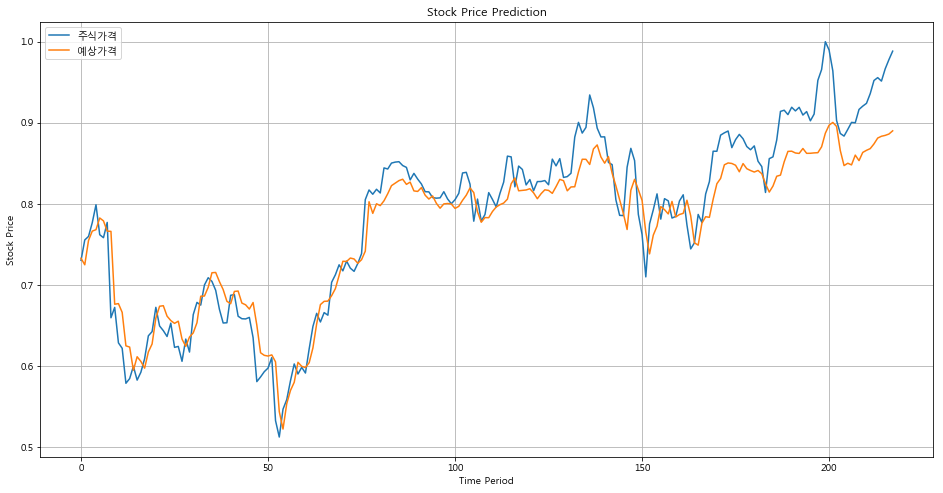

In [30]:
# %matplotlib notebook
# plt.rcParams["figure.figsize"] = [10,6]

%matplotlib inline
plt.rcParams["figure.figsize"] = [16,8]

plt.plot(testY, label='주식가격')
plt.plot(testPredict, label='예상가격')
plt.legend()
plt.grid()
plt.title('Stock Price Prediction')
plt.xlabel("Time Period")
plt.ylabel("Stock Price")
plt.show()


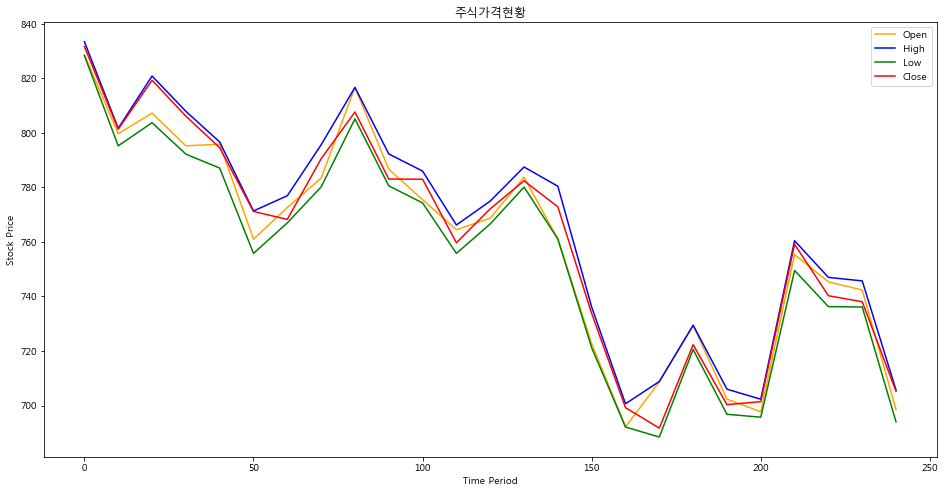

In [31]:
t_start = 0
t_end   = len(stock_df)
t_end   = 250
t_step  = 10
draw_graph(stock_df, t_start, t_end, t_step, show_volume=False)

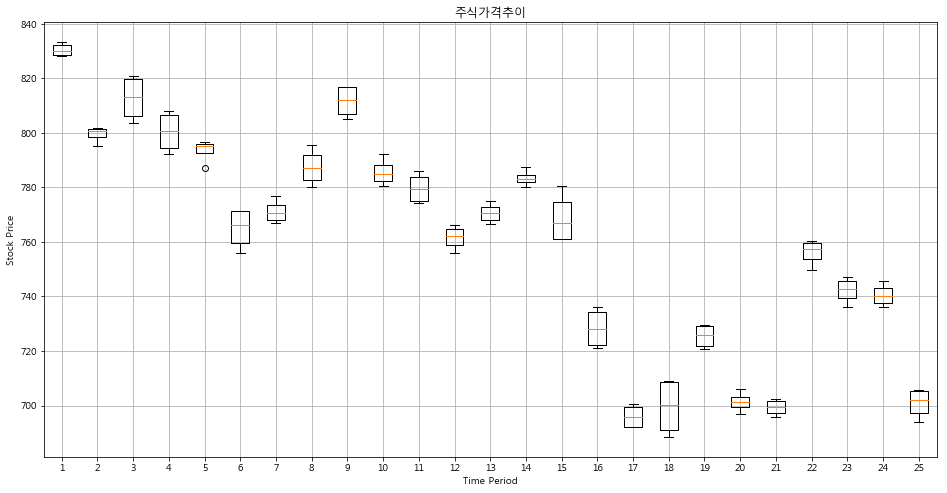

In [32]:
draw_candle(stock_df, t_start, t_end, t_step)

<hr>
<marquee><font size=3 color='brown'>The BigpyCraft find the information to design valuable society with Technology & Craft.</font></marquee>
<div align='right'><font size=2 color='gray'> &lt; The End &gt; </font></div>